In [1]:
pip version lgbm

ERROR: unknown command "version"
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("NBA_Dataset.csv")


data.head()

,Team,Points_Scored,Weightlifting_Sessions_Average,Yoga_Sessions_Average,Laps_Run_Per_Practice_Average,Water_Intake,Players_Absent_For_Sessions
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


In [4]:
data.shape

(159, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Team                            159 non-null    object 
 1   Points_Scored                   159 non-null    int64  
 2   Weightlifting_Sessions_Average  150 non-null    float64
 3   Yoga_Sessions_Average           139 non-null    float64
 4   Laps_Run_Per_Practice_Average   145 non-null    float64
 5   Water_Intake                    145 non-null    float64
 6   Players_Absent_For_Sessions     130 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.8+ KB


## rename columns

In [6]:
df = data.rename(columns={"Points_Scored": "Points","Weightlifting_Sessions_Average": "Weight Lifting", "Yoga_Sessions_Average" : "Yoga", "Laps_Run_Per_Practice_Average" : "Laps", " Laps_Run_Per_Practice_Average" : "Laps", "Water_Intake":"Water Intake", "Players_Absent_For_Sessions" : "Absentees"   })

In [7]:
df.head()

,Team,Points,Weight Lifting,Yoga,Laps,Water Intake,Absentees
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


## investigate the response variable

<Axes: xlabel='Points', ylabel='Density'>

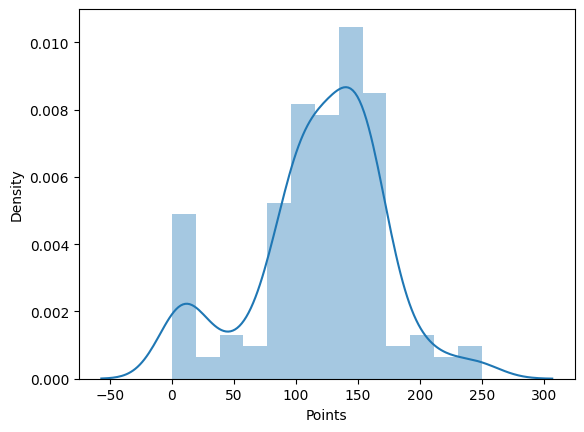

In [8]:
sns.distplot(df.Points)

<Axes: ylabel='Points'>

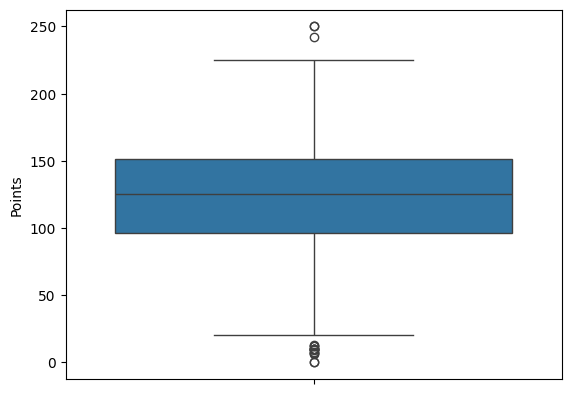

In [9]:
sns.boxplot(df.Points)

## plot violin and box plots for the teams

In [10]:
def plot_violin_box_plots(df, x, y):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle("Violin and box plots for variable {} :".format(y))

    sns.violinplot(ax=axes[0], x=x, y=y, data=df)
    sns.boxplot(ax=axes[1], data=df[y])

    axes[0].set_title("Violin plot for variable: {}".format(y))
    axes[1].set_title("Box plot for variable: {}".format(y))

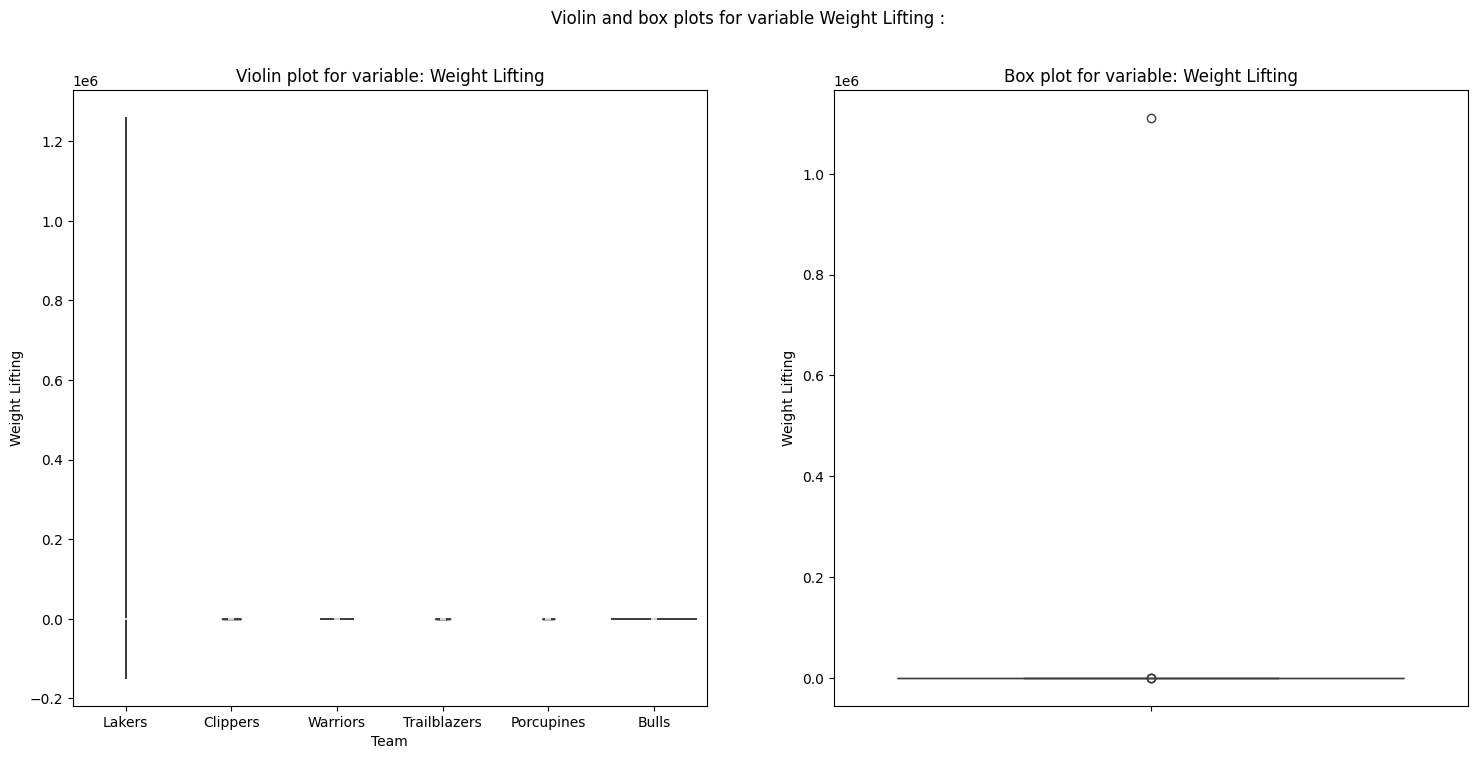

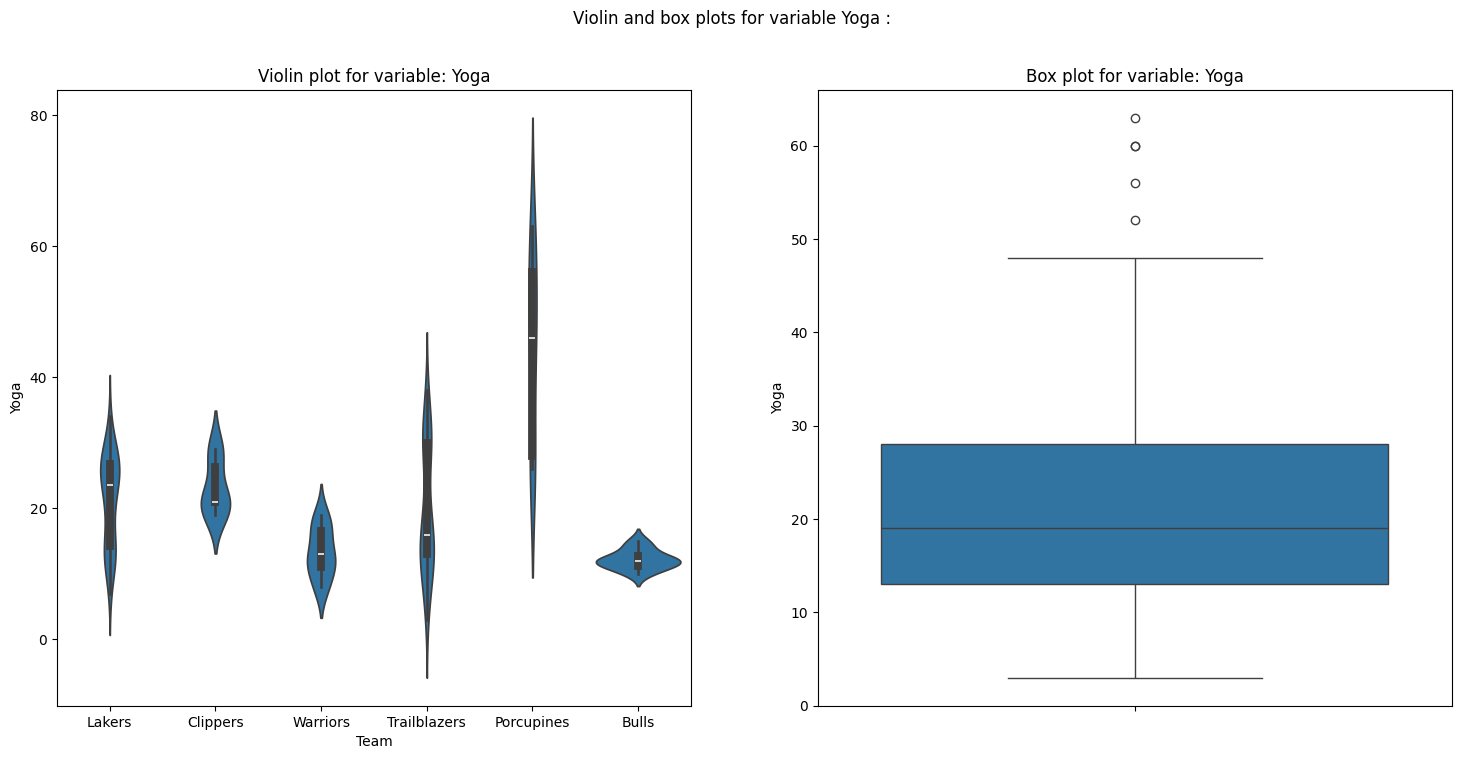

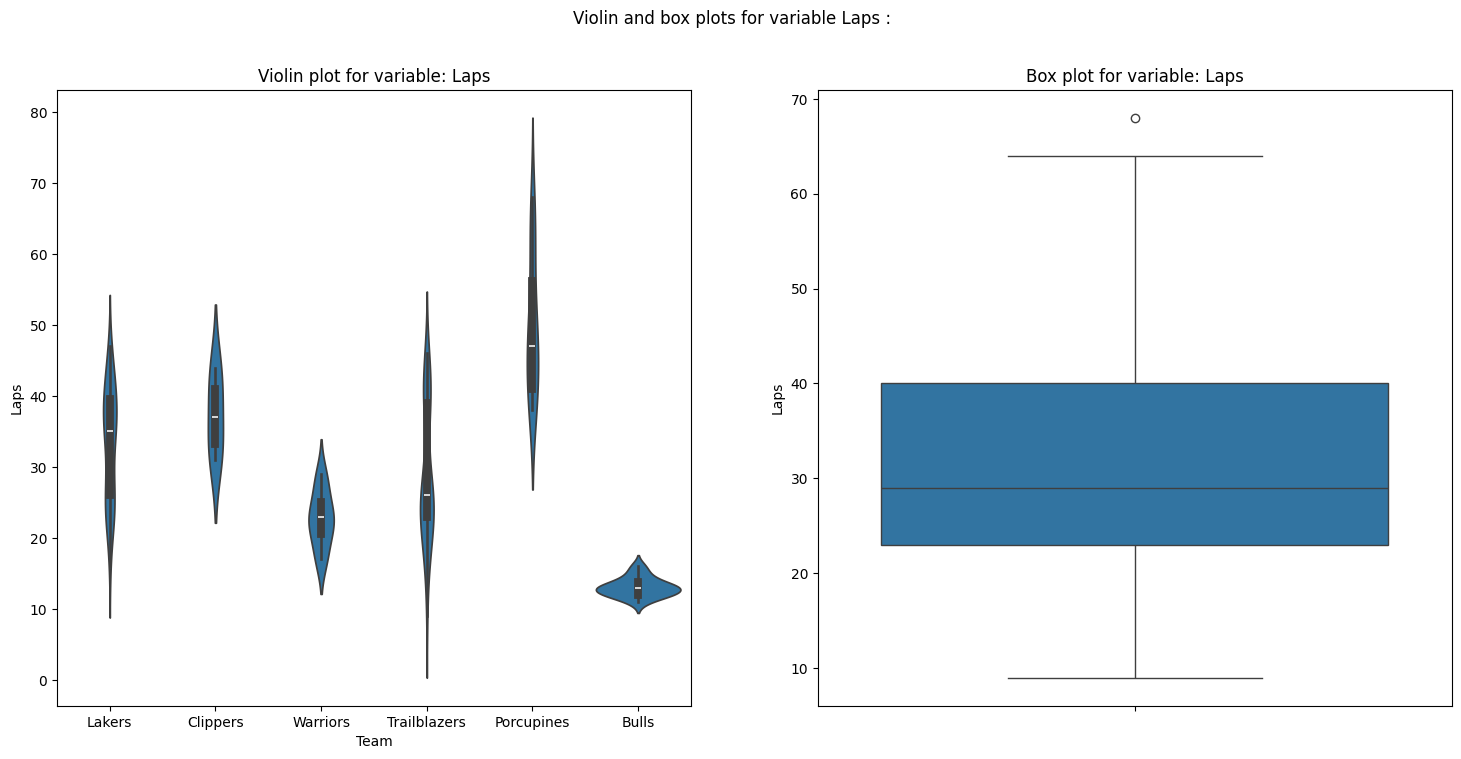

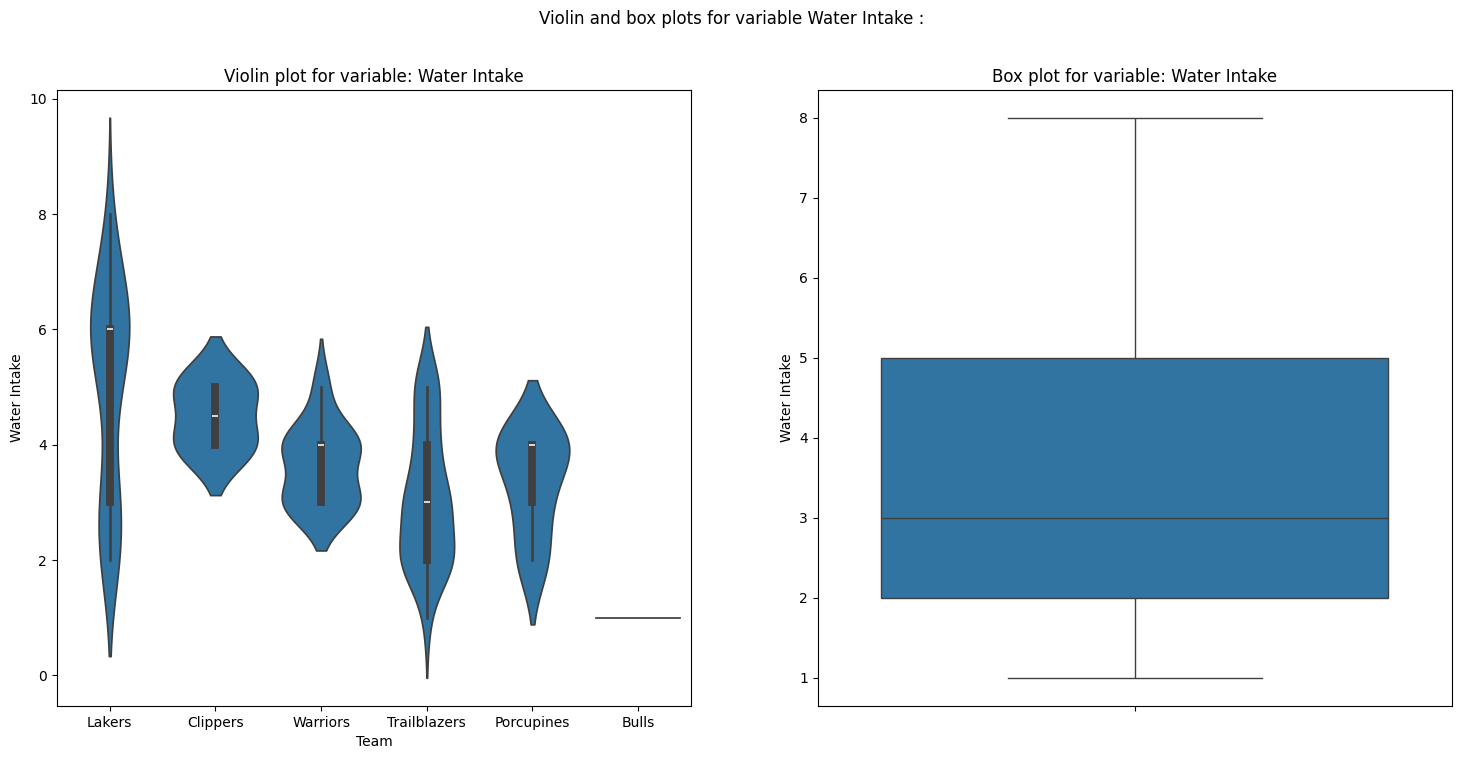

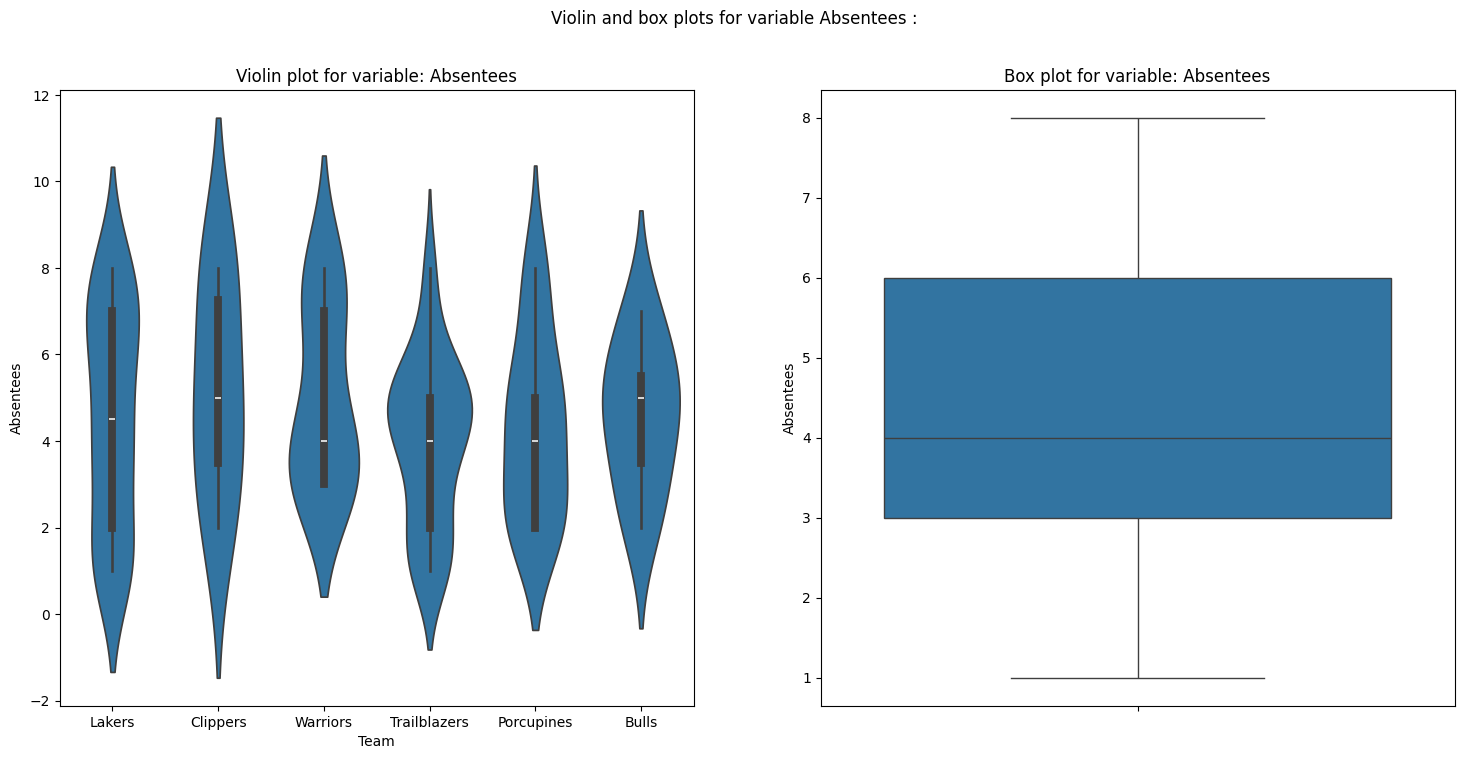

In [11]:
for y in ["Weight Lifting",	"Yoga",	"Laps",	"Water Intake",	"Absentees"]:
    plot_violin_box_plots(df, "Team", y)

In [12]:
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    Upper_end = Q3 + 1.5*Q3
    Lower_end = Q1 - 1.5*Q1


    outlier = df[column][(df[column] > Upper_end) | (df[column] < Lower_end)]

    return outlier;

In [13]:
for column in ["Weight Lifting","Yoga",	"Laps",	"Water Intake",	"Absentees"]:

    print('\n Outliers in column %s' %column)
    outlier = find_outliers(df, column)

    print(outlier)


 Outliers in column Weight Lifting
8    1111111.0
Name: Weight Lifting, dtype: float64

 Outliers in column Yoga
Series([], Name: Yoga, dtype: float64)

 Outliers in column Laps
Series([], Name: Laps, dtype: float64)

 Outliers in column Water Intake
Series([], Name: Water Intake, dtype: float64)

 Outliers in column Absentees
Series([], Name: Absentees, dtype: float64)


In [14]:
df['Weight Lifting'][df["Weight Lifting"] == 1111111.0] = np.nan

In [15]:
df['Weight Lifting'][df["Weight Lifting"] == 1111111.0]

Series([], Name: Weight Lifting, dtype: float64)

## Find missing values

In [16]:
ncounts = pd.DataFrame([df.isna().mean()]).T

ncounts

,0
Team,0.000000
Points,0.000000
Weight Lifting,0.062893
Yoga,0.125786
Laps,0.088050
Water Intake,0.088050
Absentees,0.182390


<Axes: title={'center': 'Null values according to the size of their mean'}>

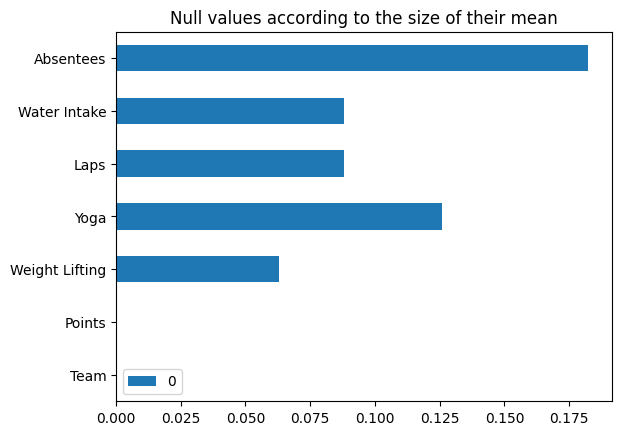

In [17]:
ncounts.plot(kind="barh", title="Null values according to the size of their mean")

### There are several ways to handle null values

* Pandas Imputer
* Iterative and KNN Imputer
* LGBM Imputer

### Pandas Imputer

<Axes: xlabel='Weight Lifting', ylabel='Density'>

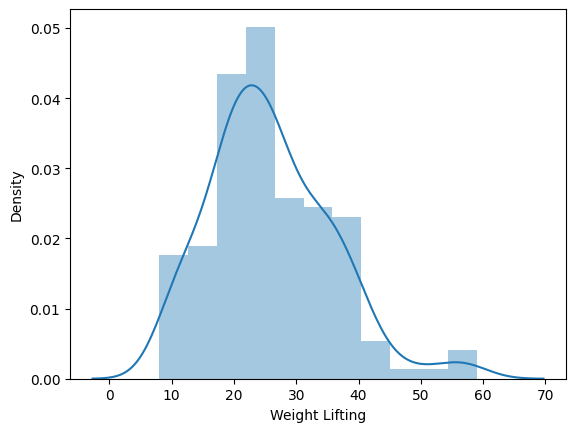

In [18]:
sns.distplot(df["Weight Lifting"].fillna(df["Weight Lifting"].mean()))

<Axes: xlabel='Weight Lifting', ylabel='Density'>

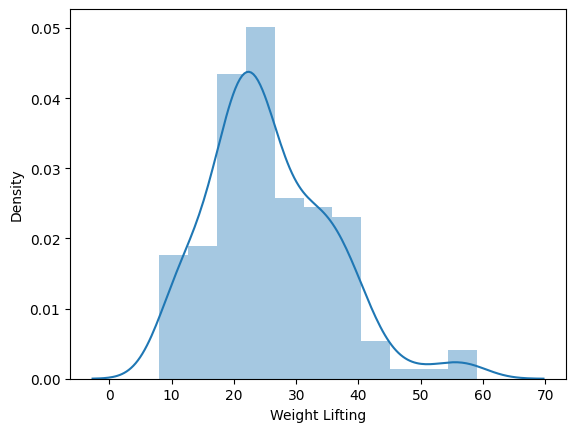

In [19]:
sns.distplot(df["Weight Lifting"].fillna(df["Weight Lifting"].median()))

In [20]:
df["Weight Lifting"]

0      23.0
1      24.0
2      24.0
3      26.0
4      27.0
       ... 
154    12.0
155    12.0
156    12.0
157    13.0
158    14.0
Name: Weight Lifting, Length: 159, dtype: float64

### instead of using the mean and median of the entire dataset, we use the mean of each column

In [21]:
Weight_Lifting_mean = df.groupby("Team")["Weight Lifting"].mean().to_dict()

Weight_Lifting_mean

{'Bulls': 11.214285714285714,
 'Clippers': 29.0,
 'Lakers': 26.04255319148936,
 'Porcupines': 42.529411764705884,
 'Trailblazers': 25.425925925925927,
 'Warriors': 18.727272727272727}

In [22]:
Weight_Lifting_Series = df["Weight Lifting"].replace(Weight_Lifting_mean)

Weight_Lifting_Series

0      23.0
1      24.0
2      24.0
3      26.0
4      27.0
       ... 
154    12.0
155    12.0
156    12.0
157    13.0
158    14.0
Name: Weight Lifting, Length: 159, dtype: float64

<Axes: xlabel='Weight Lifting', ylabel='Density'>

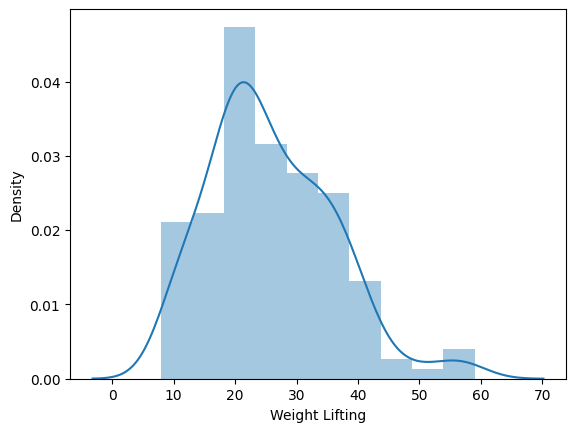

In [23]:
sns.distplot(df["Weight Lifting"].replace(Weight_Lifting_mean))

## SKlearn Imputer

In [24]:
features = ["Weight Lifting","Yoga","Laps",	"Water Intake",	"Absentees"]

from sklearn.impute import SimpleImputer
impt = SimpleImputer(strategy="mean")

si_impt = impt.fit_transform(df[features])
si_impt_df = pd.DataFrame(si_impt, columns=features)

In [25]:
si_impt_df

,Weight Lifting,Yoga,Laps,Water Intake,Absentees
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,21.690647,34.0,5.0,6.000000
...,...,...,...,...,...
154,12.0,12.000000,13.0,1.0,4.415385
155,12.0,12.000000,14.0,1.0,4.415385
156,12.0,13.000000,14.0,1.0,4.415385
157,13.0,14.000000,15.0,1.0,6.000000


### Iterative Imputer

In [26]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

ITI = IterativeImputer(max_iter=10)

ITI_impt = ITI.fit_transform(df[features])

ITI_impt_df = pd.DataFrame(ITI_impt, columns=features)

ITI_impt_df

,Weight Lifting,Yoga,Laps,Water Intake,Absentees
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,22.057489,34.0,5.0,6.000000
...,...,...,...,...,...
154,12.0,12.000000,13.0,1.0,4.411840
155,12.0,12.000000,14.0,1.0,4.411953
156,12.0,13.000000,14.0,1.0,4.412054
157,13.0,14.000000,15.0,1.0,6.000000


## KNN Imputer

In [27]:
from sklearn.impute import KNNImputer

KNN = KNNImputer(n_neighbors=5)

KNN_impt = KNN.fit_transform(df[features])
KNN_impt_df = pd.DataFrame(KNN_impt, columns=features)

df_new = KNN_impt_df 

df_new

,Weight Lifting,Yoga,Laps,Water Intake,Absentees
0,23.0,25.0,30.0,5.0,4.0
1,24.0,26.0,31.0,5.0,8.0
2,24.0,27.0,31.0,5.0,7.0
3,26.0,29.0,34.0,5.0,1.0
4,27.0,21.8,34.0,5.0,6.0
...,...,...,...,...,...
154,12.0,12.0,13.0,1.0,5.0
155,12.0,12.0,14.0,1.0,5.0
156,12.0,13.0,14.0,1.0,5.2
157,13.0,14.0,15.0,1.0,6.0


### LGBM Imputer

In [28]:
!git clone https://github.com/analokmaus/kuma_utils.git

fatal: destination path 'kuma_utils' already exists and is not an empty directory.


In [29]:
import sys

sys.path.append("kuma_utils/")pip install lightgbm


SyntaxError: invalid syntax (4210983738.py, line 3)

In [ ]:
!pip install lightgbm

In [ ]:
from kuma_utils.preprocessing.imputer import LGBMImputer

## Univariate analysis

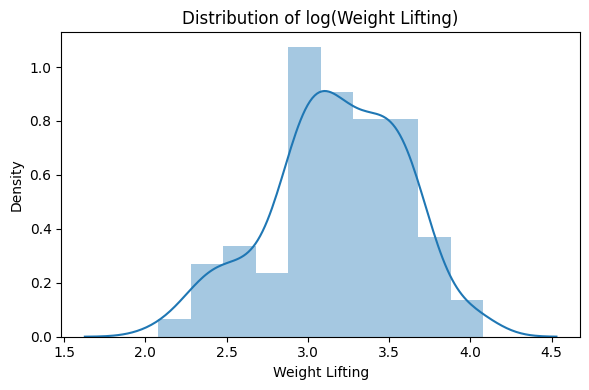

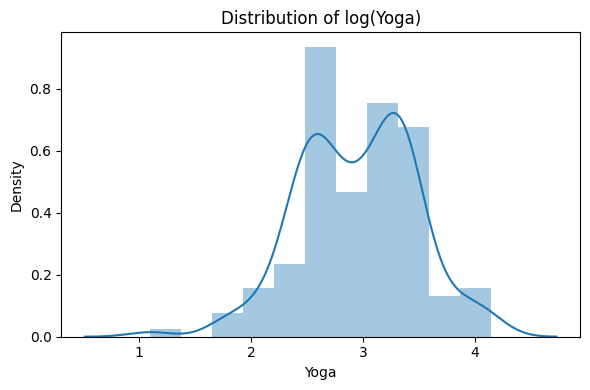

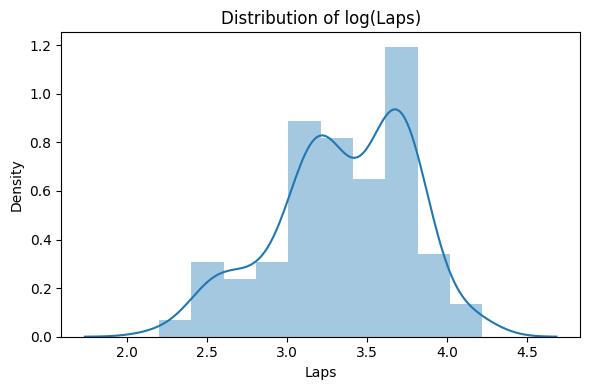

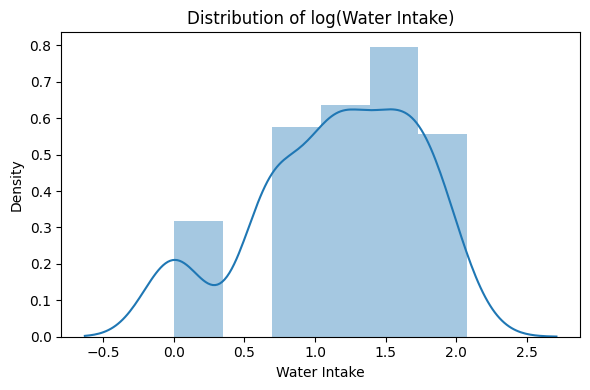

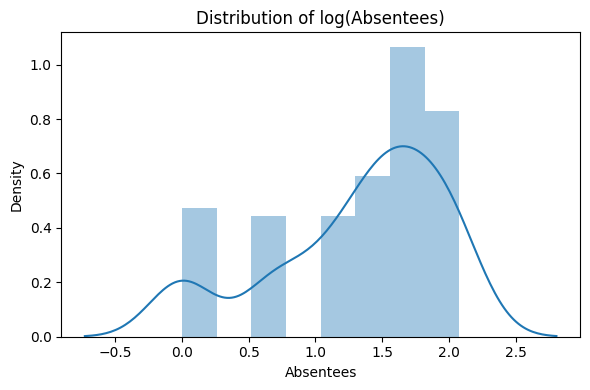

In [30]:
for column in features:
  fig, axes = plt.subplots(1, 1, figsize=(6, 4))
  sns.distplot(np.log(df[column]))
  plt.title(f"Distribution of log({column})")
  plt.xlabel(column)  
  plt.tight_layout()
  plt.show()


## Bivariate Analysis

<Axes: >

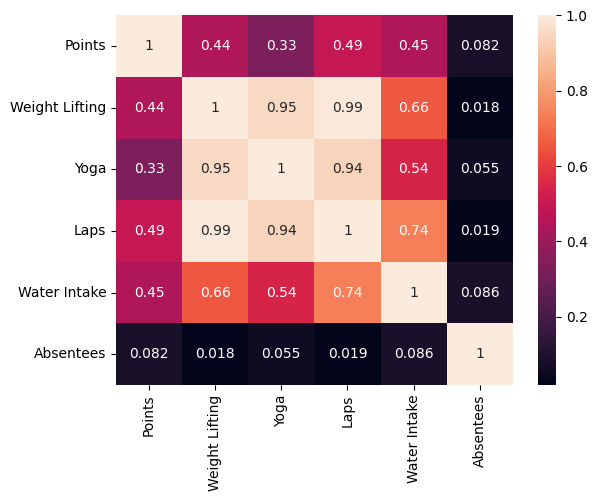

In [31]:
num_cols = df.select_dtypes(exclude="object")

sns.heatmap(num_cols.corr(), annot=True )

In [32]:
df.select_dtypes(exclude="object").corr().T

,Points,Weight Lifting,Yoga,Laps,Water Intake,Absentees
Points,1.000000,0.443511,0.332592,0.491508,0.445659,0.082339
Weight Lifting,0.443511,1.000000,0.953869,0.992710,0.655399,0.018104
Yoga,0.332592,0.953869,1.000000,0.940310,0.543041,0.055114
Laps,0.491508,0.992710,0.940310,1.000000,0.737882,0.018933
Water Intake,0.445659,0.655399,0.543041,0.737882,1.000000,0.086381
Absentees,0.082339,0.018104,0.055114,0.018933,0.086381,1.000000


In [33]:
df_new["Points"] = df["Points"]
df_new["Team"] = df["Team"]

df_new.shape, df.shape

((159, 7), (159, 7))

### Charterjee correlation

In [34]:
def charter_jee_corr(df, x, y):
    N = df.shape[0]
    df_rank = df

    df_rank["rank_y"] = df_rank[y].rank()
    df_rank["rank_x"] = df_rank[x].rank()
    df_rank = df_rank.sort_values(by="rank_x")

    chatt_corr = 1-3*df_rank["rank_y"].diff().abs().sum() / (pow(N, 2)-1)

    return chatt_corr



In [35]:
features = ["Weight Lifting","Yoga","Laps","Water Intake","Absentees"]

In [36]:
for column in features:
    print(f"The charter_jee correlation for {column} is : ",charter_jee_corr(df_new, column, "Points"))

The charter_jee correlation for Weight Lifting is :  0.37377373417721516
The charter_jee correlation for Yoga is :  0.2789556962025317
The charter_jee correlation for Laps is :  0.3711629746835443
The charter_jee correlation for Water Intake is :  0.3234572784810127
The charter_jee correlation for Absentees is :  -0.0040150316455696


## Simple Anova

In [37]:
import random

nba_id = list(df_new.index.unique())

random.seed()

print(nba_id)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]


In [38]:
sample_match_id = random.sample(nba_id, 50)

sample_match_id

[124,
 31,
 19,
 157,
 66,
 146,
 122,
 51,
 158,
 82,
 90,
 83,
 107,
 136,
 47,
 150,
 156,
 61,
 143,
 24,
 86,
 36,
 132,
 55,
 113,
 76,
 151,
 85,
 153,
 10,
 72,
 96,
 97,
 17,
 121,
 135,
 29,
 106,
 1,
 9,
 13,
 35,
 134,
 112,
 133,
 68,
 100,
 138,
 93,
 37]

In [39]:
sample_df = df_new[df_new.index.isin(sample_match_id)].reset_index(drop=True)

sample_df.head()

,Weight Lifting,Yoga,Laps,Water Intake,Absentees,Points,Team,rank_y,rank_x
0,24.0,26.0,31.0,5.0,8.0,144,Lakers,100.0,152.0
1,29.0,26.0,36.0,6.0,4.4,147,Lakers,107.0,79.0
2,28.0,21.0,36.0,6.0,5.0,140,Lakers,95.0,97.0
3,30.0,27.0,37.0,6.0,5.8,168,Lakers,143.5,117.5
4,30.0,25.0,39.0,6.0,8.0,147,Lakers,107.0,152.0


In [40]:
sample_df = sample_df[["Team", "Points"]]

groups = sample_df.groupby("Team").count().reset_index()

In [41]:
groups

,Team,Points
0,Bulls,7
1,Clippers,1
2,Lakers,14
3,Porcupines,7
4,Trailblazers,18
5,Warriors,3


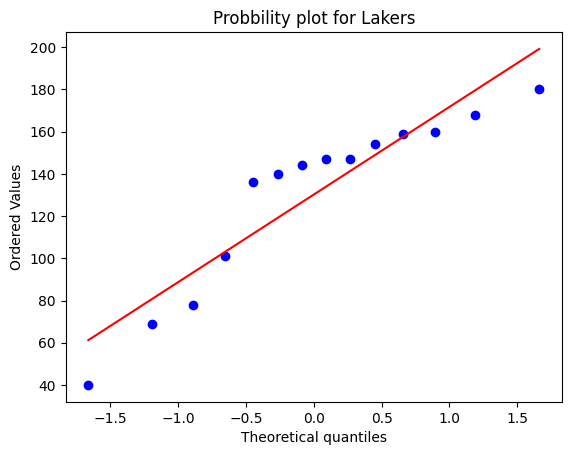

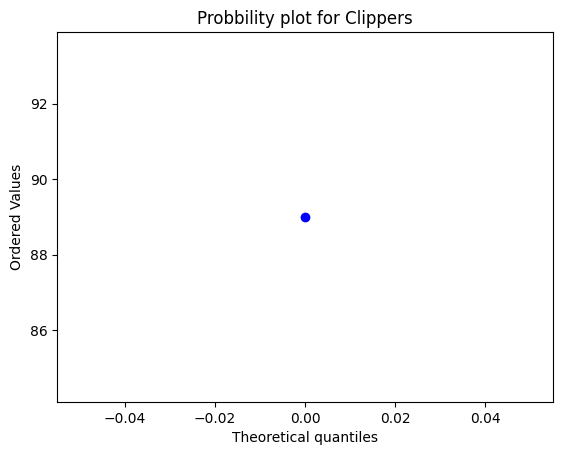

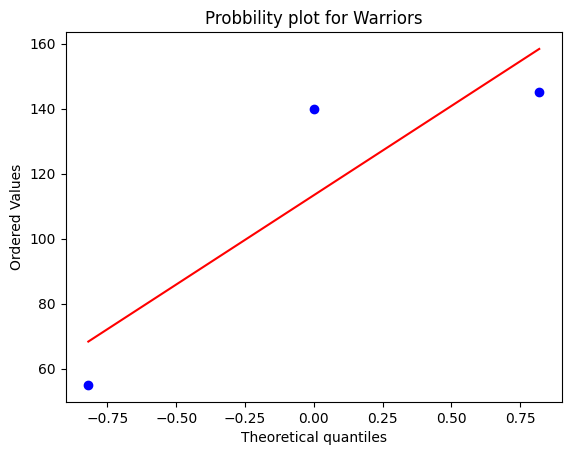

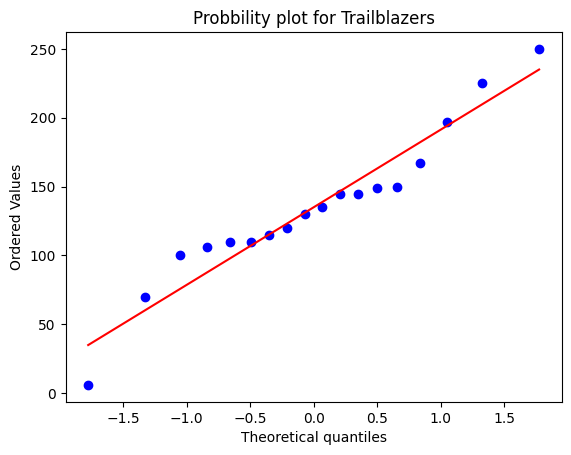

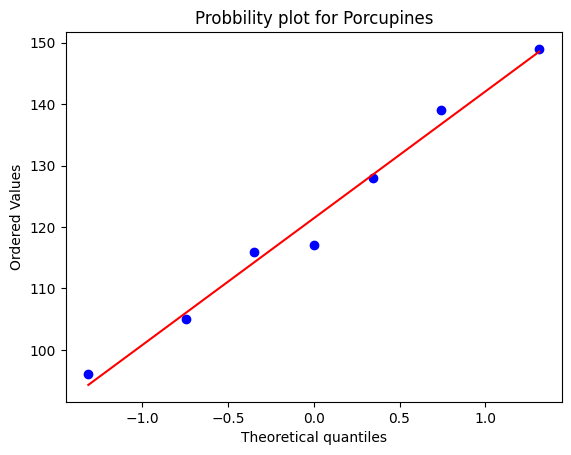

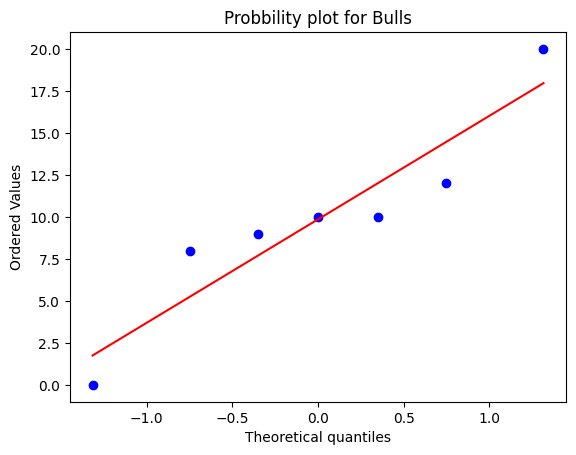

In [42]:
from scipy import stats 

unique_teams = sample_df["Team"].unique()

for unique_team in unique_teams:
    stats.probplot(sample_df[sample_df["Team"] == unique_team] ["Points"], dist='norm', plot=plt)
    plt.title("Probbility plot for " + unique_team)
    plt.show()

In [43]:
ratio = sample_df.groupby("Team").std().max() / sample_df.groupby("Team").std().min()

ratio

Points    9.342107
dtype: float64

## implementing anova from scratch

In [44]:
data = [["Between Groups", "", "", "", "", "", ""],["Within Groups", "", "", "", "", "", ""],["Total", "", "", "", "", "", ""]]

anova_table = pd.DataFrame(data, columns=["Variation", "SS", "df", "MS", "F value", "P value", "F critical"])

anova_table.set_index("Variation", inplace=True)

In [45]:
x_bar = sample_df["Points"].mean()

x_bar

112.02

In [46]:
SSTR = sample_df.groupby("Team").count()*(sample_df.groupby("Team").mean() - x_bar)**2

In [47]:
anova_table["SS"]["Between Groups"] = SSTR["Points"].sum()

In [48]:
anova_table

,SS,df,MS,F value,P value,F critical
Variation,,,,,,
Between Groups,88355.384762,,,,,
Within Groups,,,,,,
Total,,,,,,


In [49]:
SSE = (sample_df.groupby("Team").count()-1)*sample_df.groupby("Team").std()**2

SSE

,Points
Team,
Bulls,208.857143
Clippers,NaN
Lakers,22536.357143
Porcupines,2077.714286
Trailblazers,51646.000000
Warriors,5116.666667


In [50]:
anova_table["SS"]["Within Groups"] = SSE["Points"].sum()

anova_table

,SS,df,MS,F value,P value,F critical
Variation,,,,,,
Between Groups,88355.384762,,,,,
Within Groups,81585.595238,,,,,
Total,,,,,,


In [51]:
total = SSTR["Points"].sum() + SSE["Points"].sum()

total

169940.97999999998

In [52]:
anova_table["SS"]["Total"] = total

anova_table

,SS,df,MS,F value,P value,F critical
Variation,,,,,,
Between Groups,88355.384762,,,,,
Within Groups,81585.595238,,,,,
Total,169940.98,,,,,


In [53]:
anova_table["df"]["Between Groups"] = sample_df["Team"].nunique() - 1
anova_table["df"]["Within Groups"] = sample_df.shape[0] - sample_df["Team"].nunique()
anova_table["df"]["Total"] = sample_df.shape[0] - 1

In [54]:
anova_table

,SS,df,MS,F value,P value,F critical
Variation,,,,,,
Between Groups,88355.384762,5,,,,
Within Groups,81585.595238,44,,,,
Total,169940.98,49,,,,


In [55]:
anova_table["MS"] = anova_table["SS"]/anova_table["df"]
anova_table["F value"]["Between Groups"] = anova_table["MS"]["Between Groups"] / anova_table["MS"]["Within Groups"]
anova_table["P value"]["Between Groups"] = 1-stats.f.cdf(anova_table["F value"]["Between Groups"],
                                                         anova_table["df"]["Between Groups"],
                                                         anova_table["df"]["Within Groups"])
anova_table

,SS,df,MS,F value,P value,F critical
Variation,,,,,,
Between Groups,88355.384762,5,17671.076952,9.530204,0.000003,
Within Groups,81585.595238,44,1854.218074,,,
Total,169940.98,49,3468.183265,,,


In [56]:
alpha = 0.05

hypothesis_type = "two-tailed"

if hypothesis_type == "two-tailed":
    alpha = alpha / 2

    anova_table["F critical"]["Between Groups"] = stats.f.ppf(1 - alpha,
                                                              anova_table["df"]["Between Groups"],
                                                              anova_table["df"]["Within Groups"])

anova_table


,SS,df,MS,F value,P value,F critical
Variation,,,,,,
Between Groups,88355.384762,5,17671.076952,9.530204,0.000003,2.871184
Within Groups,81585.595238,44,1854.218074,,,
Total,169940.98,49,3468.183265,,,


In [57]:
print("Approach for P value")

conclusion = "Failed to reject null hypothesis"

if anova_table["P value"]["Between Groups"] <= alpha:
    conclusion = "Null hypothesis is rejected"

print("F value for the table is",  anova_table["F value"]["Between Groups"], "and p value is", anova_table["P value"]["Between Groups"])
print(conclusion)

Approach for P value
F value for the table is 9.530204242987569 and p value is 3.270679960643008e-06
Null hypothesis is rejected


In [58]:
print("Approach for F critical")

conclusion = "Failed to reject null hypothesis"

if anova_table["F value"]["Between Groups"] > anova_table["F critical"]["Between Groups"] :
    conclusion = "Null hypothesis is rejected"

print("F value for the table is",  anova_table["F value"]["Between Groups"], "and F critical is", anova_table["F critical"]["Between Groups"])
print(conclusion)

Approach for F critical
F value for the table is 9.530204242987569 and F critical is 2.871183837102218
Null hypothesis is rejected


In [59]:
#processing data for modelling

one_hot_df = pd.get_dummies(df_new, columns=["Team"], drop_first= True)

one_hot_df

,Weight Lifting,Yoga,Laps,Water Intake,Absentees,Points,rank_y,rank_x,Team_Clippers,Team_Lakers,Team_Porcupines,Team_Trailblazers,Team_Warriors
0,23.0,25.0,30.0,5.0,4.0,242,157.0,64.5,False,True,False,False,False
1,24.0,26.0,31.0,5.0,8.0,144,100.0,152.0,False,True,False,False,False
2,24.0,27.0,31.0,5.0,7.0,156,126.5,138.0,False,True,False,False,False
3,26.0,29.0,34.0,5.0,1.0,159,129.5,8.5,False,True,False,False,False
4,27.0,21.8,34.0,5.0,6.0,106,54.5,125.5,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,12.0,12.0,13.0,1.0,5.0,12,13.5,97.0,False,False,False,False,False
155,12.0,12.0,14.0,1.0,5.0,13,15.0,97.0,False,False,False,False,False
156,12.0,13.0,14.0,1.0,5.2,12,13.5,111.5,False,False,False,False,False
157,13.0,14.0,15.0,1.0,6.0,20,16.0,125.5,False,False,False,False,False


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X = one_hot_df[["Weight Lifting",	"Yoga",	"Laps",	"Water Intake"	,"Absentees",	"rank_y",	"rank_x",	"Team_Clippers",	"Team_Lakers",	"Team_Porcupines",	"Team_Trailblazers",	"Team_Warriors"]]
y = one_hot_df["Points"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=100) 

In [61]:
#print the dimensions

print("X_train dimension is ", X_train.shape)
print("X_test dimension is ", X_test.shape)
print("y_train dimension is ", y_train.shape)
print("y_test dimension is ", y_test.shape)

X_train dimension is  (127, 12)
X_test dimension is  (32, 12)
y_train dimension is  (127,)
y_test dimension is  (32,)


In [62]:
#Start Imputing here

imputer = KNNImputer(n_neighbors=5)

X_train_imputed = imputer.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_imputed, columns=X_train.columns)

X_train_df

,Weight Lifting,Yoga,Laps,Water Intake,Absentees,rank_y,rank_x,Team_Clippers,Team_Lakers,Team_Porcupines,Team_Trailblazers,Team_Warriors
0,37.0,33.0,43.0,5.0,2.0,35.0,24.0,0.0,0.0,0.0,1.0,0.0
1,18.0,11.0,22.0,4.0,3.0,115.5,39.5,0.0,0.0,0.0,0.0,1.0
2,29.0,21.0,36.0,6.0,5.2,51.0,111.5,0.0,1.0,0.0,0.0,0.0
3,30.0,23.0,37.4,6.0,3.0,88.5,39.5,0.0,1.0,0.0,0.0,0.0
4,14.0,8.0,17.0,3.0,4.0,22.0,64.5,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
122,20.0,14.0,24.0,2.0,4.0,72.5,64.5,0.0,0.0,0.0,1.0,0.0
123,25.0,18.8,29.0,3.0,5.6,88.5,114.5,0.0,0.0,0.0,1.0,0.0
124,19.0,13.0,23.0,4.0,3.0,146.5,39.5,0.0,0.0,0.0,0.0,1.0
125,32.0,27.0,41.0,6.0,4.0,129.5,64.5,0.0,1.0,0.0,0.0,0.0


In [63]:
y_train = y_train.reset_index(drop=True)
X_train_df = X_train_df.reset_index(drop=True)

In [64]:
import statsmodels.api as sm

result = sm.OLS(y_train, X_train_df).fit()

print(result.summary())


                                 OLS Regression Results                                
Dep. Variable:                 Points   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1099.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):                   1.47e-112
Time:                        21:16:53   Log-Likelihood:                         -498.65
No. Observations:                 127   AIC:                                      1021.
Df Residuals:                     115   BIC:                                      1055.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [65]:
# to make r centered, add constant value to the _train_df


X_const = sm.add_constant(X_train_df)
result = sm.OLS(y_train,X_const).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     156.7
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           6.88e-65
Time:                        21:16:53   Log-Likelihood:                -498.60
No. Observations:                 127   AIC:                             1023.
Df Residuals:                     114   BIC:                             1060.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.8821      6.35

In [66]:
X_test = pd.DataFrame(imputer.transform(X_test))

In [67]:
X_test

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.0,13.0,25.0,3.0,7.0,131.5,138.0,0.0,1.0,0.0,0.0,0.0
1,29.0,20.0,36.0,6.0,4.8,107.0,83.0,0.0,1.0,0.0,0.0,0.0
2,41.0,38.0,43.6,5.0,4.0,31.0,64.5,0.0,0.0,0.0,1.0,0.0
3,29.0,25.0,37.0,6.0,4.6,111.0,81.0,0.0,1.0,0.0,0.0,0.0
4,28.0,21.8,35.0,5.0,7.0,62.5,138.0,0.0,1.0,0.0,0.0,0.0
5,35.0,30.0,39.0,4.0,3.0,81.0,39.5,0.0,0.0,0.0,1.0,0.0
6,45.0,48.0,51.0,3.0,8.0,139.0,152.0,0.0,0.0,1.0,0.0,0.0
7,24.0,26.0,31.0,5.0,8.0,100.0,152.0,0.0,1.0,0.0,0.0,0.0
8,12.0,12.0,14.0,1.0,5.0,15.0,97.0,0.0,0.0,0.0,0.0,0.0
9,24.0,19.0,28.0,3.0,8.0,148.5,152.0,0.0,1.0,0.0,0.0,0.0


In [69]:
#predicting 


y_pred = pd.DataFrame(result.predict(sm.add_constant(X_test[[0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	10,	11]])))

y_pred

,0
0,169.010915
1,145.713632
2,85.106682
3,151.042158
4,106.236974
5,128.354605
6,179.118120
7,141.377728
8,15.867803
9,185.246888


In [70]:
X_test.columns

RangeIndex(start=0, stop=12, step=1)

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


print("Mean Absolute Error is ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error is ", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error is ",np.sqrt( mean_squared_error(y_test, y_pred)))

Mean Absolute Error is  7.648514918240773
Mean Squared Error is  151.81651125636918
Root Mean Squared Error is  12.321384307632368


In [72]:
from sklearn import metrics

print("R2_Score test is ", metrics.r2_score(y_test, y_pred))

R2_Score test is  0.9489775471409191


In [73]:
def create_polynomial_plot(feature, label):

    #convert to 1d
    x_coordinates = feature
    y_coordinates = np.squeeze(label)

    plt.figure(figsize=(12, 6))
    linear_poly = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 1))
    quadratic_poly = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 2))
    cubic_poly = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 3))

    values = np.linspace(x_coordinates.min(), x_coordinates.max(), len(x_coordinates))
    plt.scatter(x_coordinates, y_coordinates)
    plt.plot(values, linear_poly(values), color="cyan", label="Linear Model")
    plt.plot(values, quadratic_poly(values), color="orange", label="Quadratic Model")
    plt.plot(values, cubic_poly(values), color="red", label="Cubic Model")

    

    plt.xlabel(f"{feature.name} from data")
    plt.ylabel("Points")

    plt.title("Linear vs Quadratic vs Cubic")
    plt.show()

In [74]:
X_train_df.columns

Index(['Weight Lifting', 'Yoga', 'Laps', 'Water Intake', 'Absentees', 'rank_y',
       'rank_x', 'Team_Clippers', 'Team_Lakers', 'Team_Porcupines',
       'Team_Trailblazers', 'Team_Warriors'],
      dtype='object')

In [76]:
features = ['Weight Lifting', 'Yoga', 'Laps', 'Water Intake', 'Absentees', 'rank_y',
       'rank_x', 'Team_Clippers', 'Team_Lakers', 'Team_Porcupines',
       'Team_Trailblazers', 'Team_Warriors']

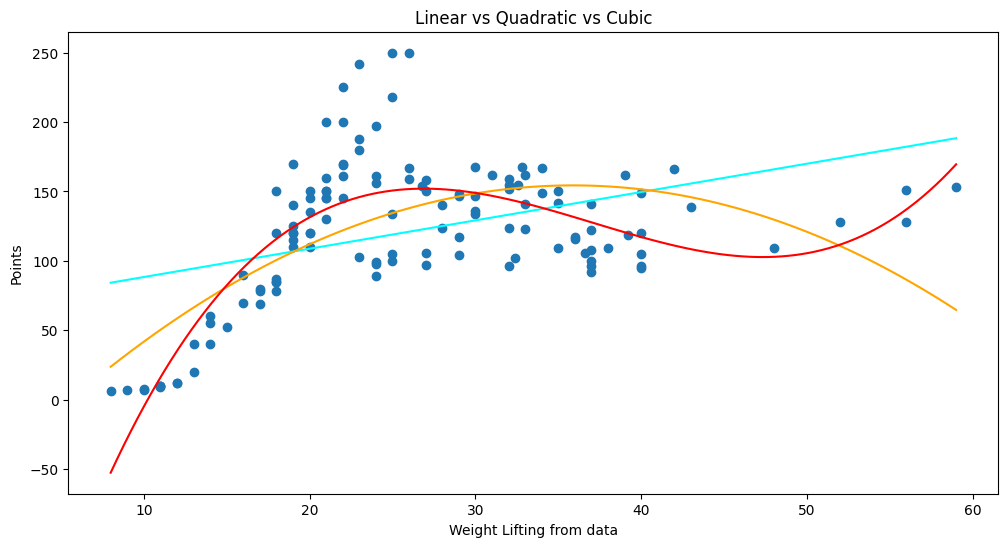

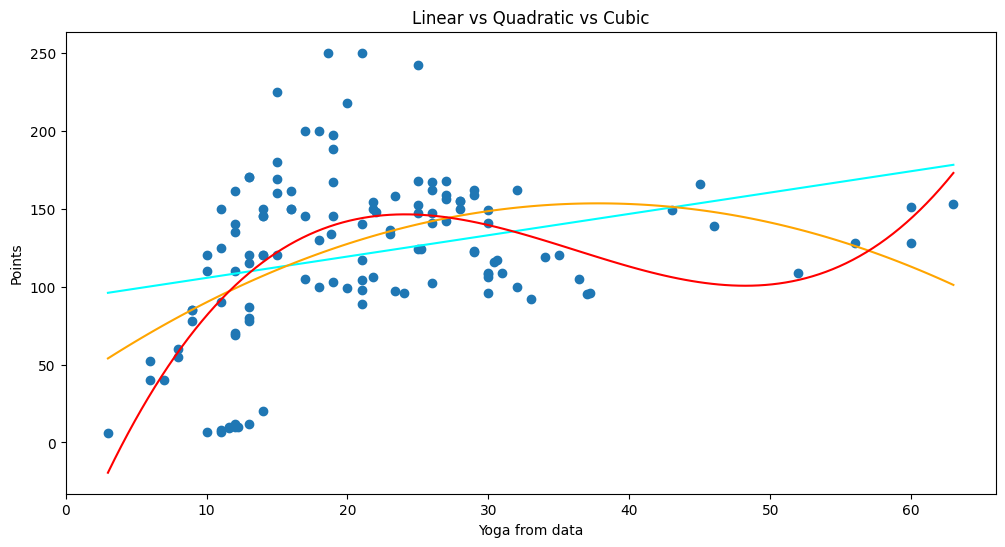

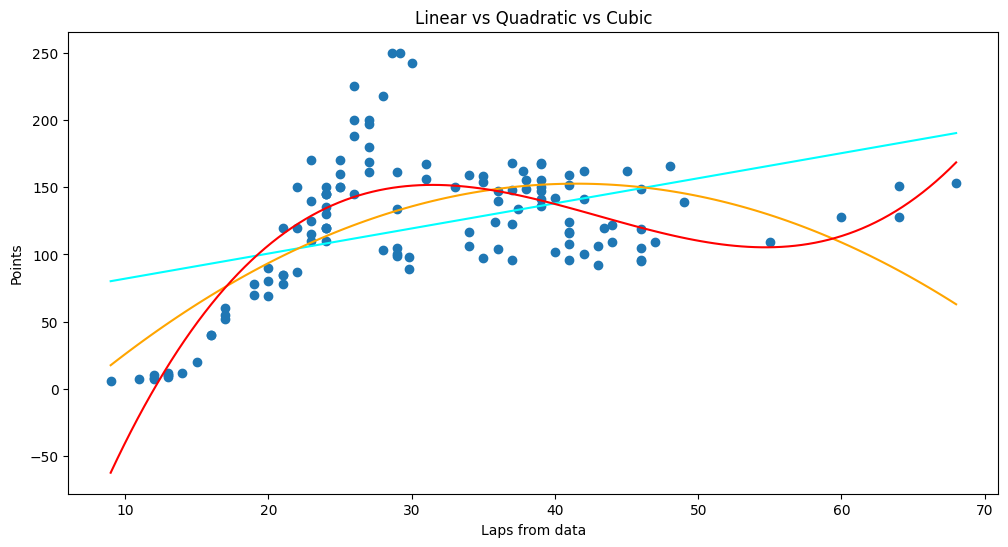

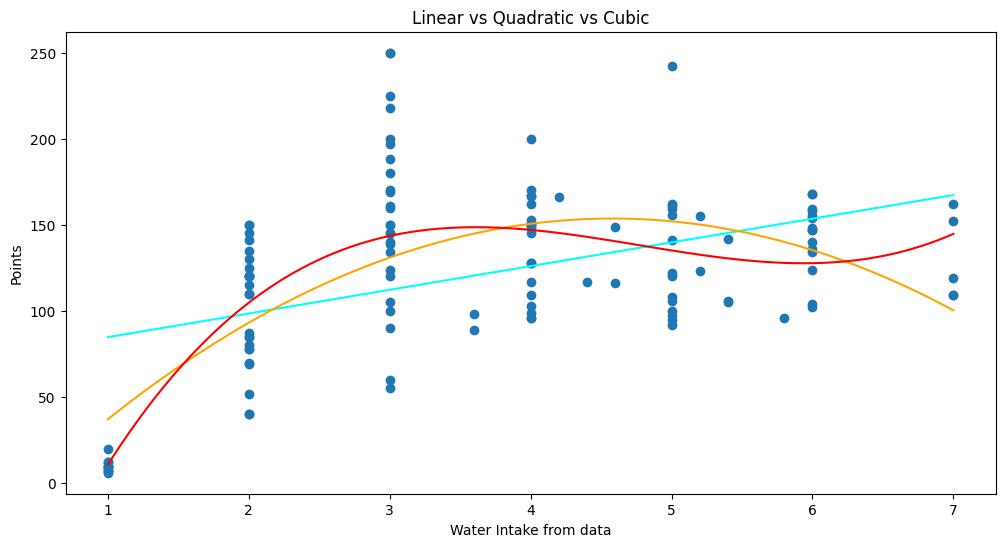

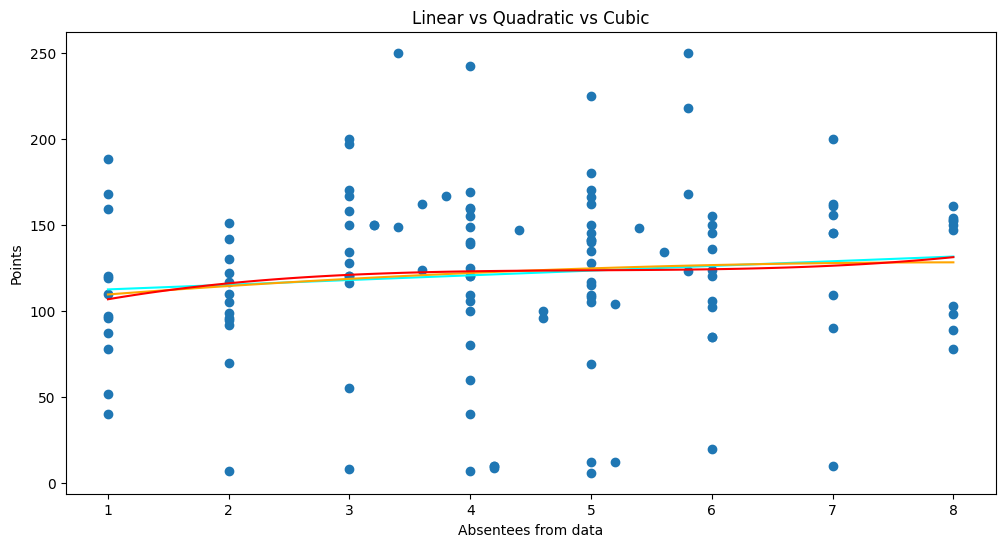

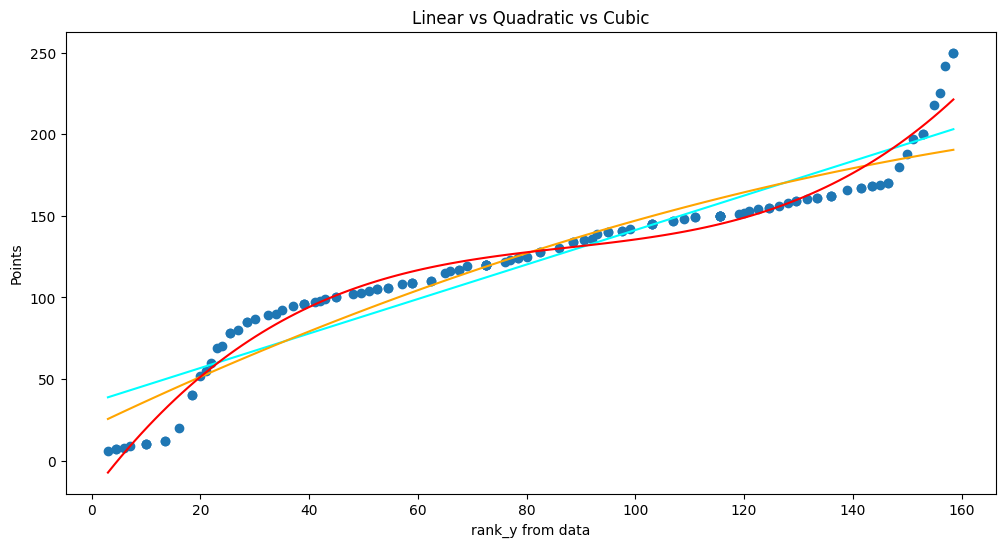

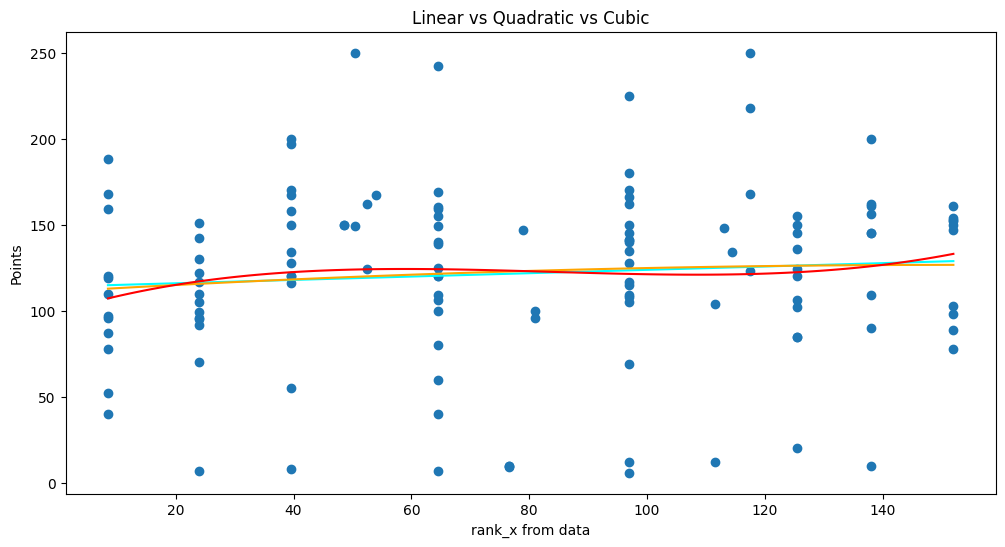

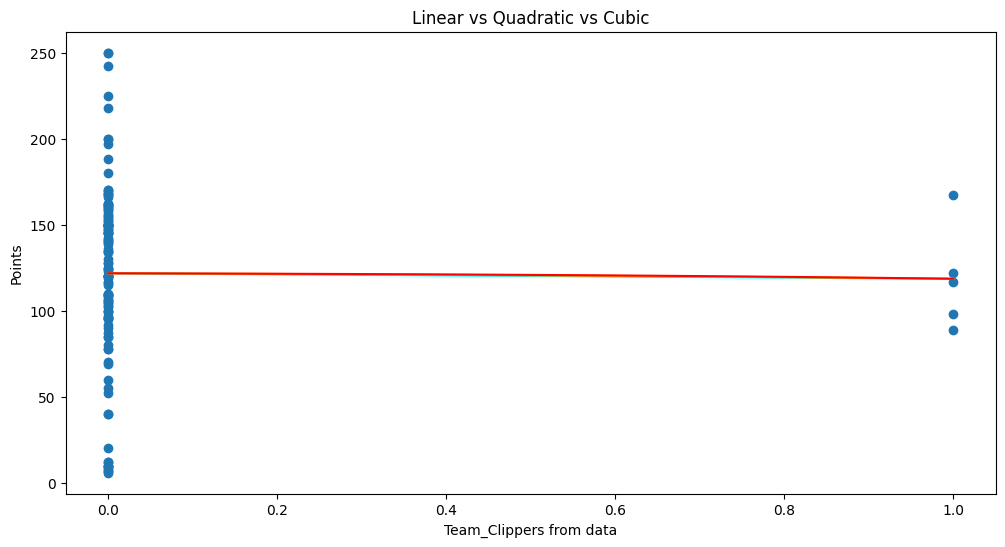

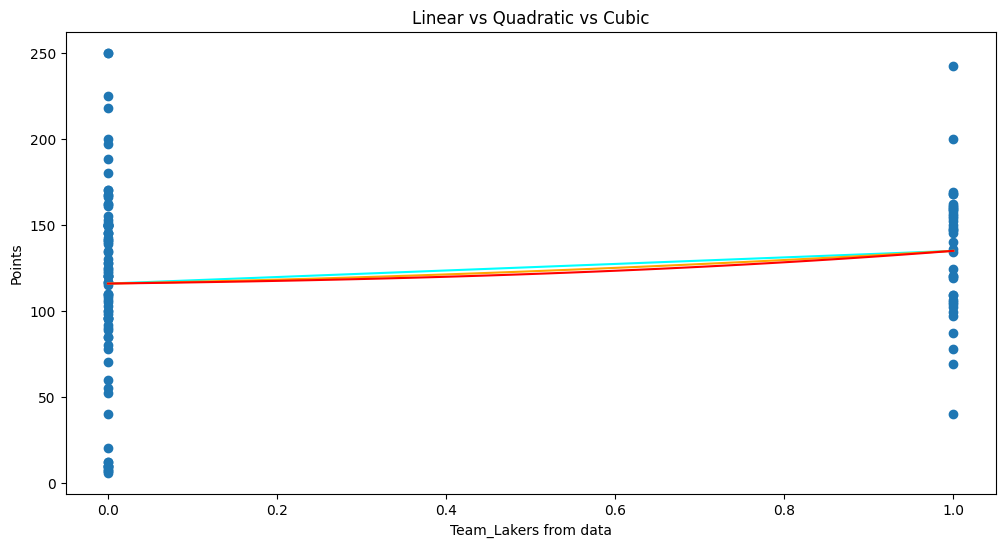

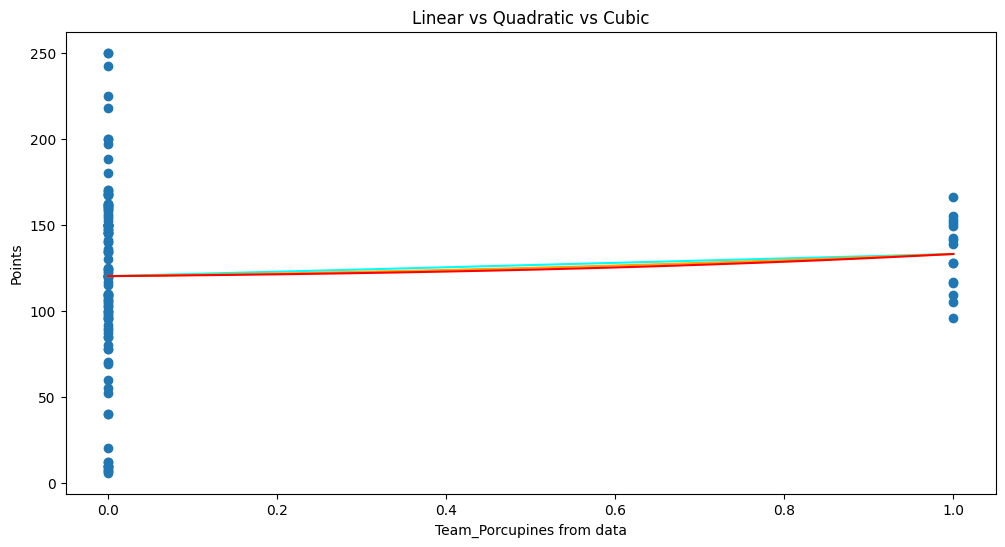

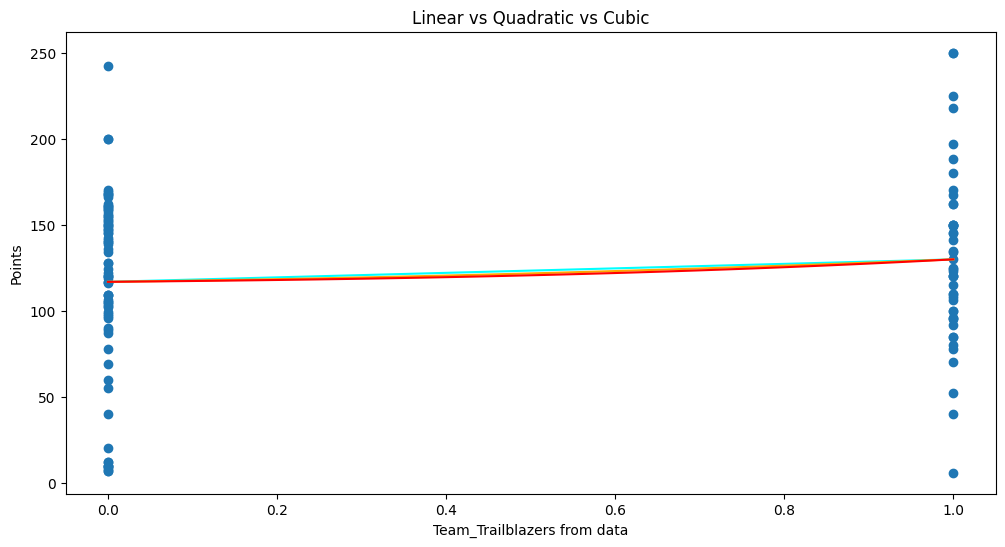

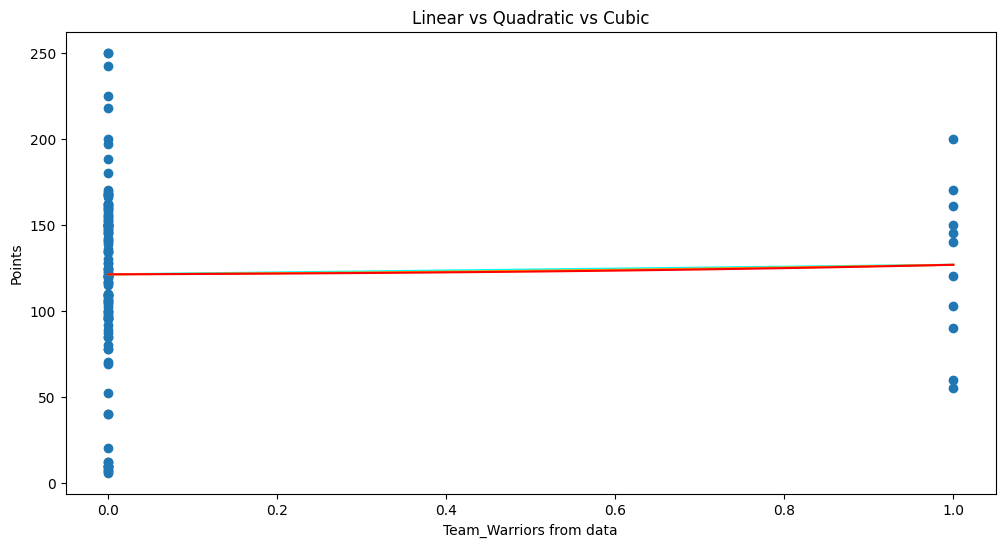

In [77]:
for feature in features:
    create_polynomial_plot(X_train_df[feature], y_train)

In [78]:
# create a set of polynomial features

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train_df)

poly.fit(X_poly, y_train)

PolynomialFeatures()

PolynomialFeatures()

In [79]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

lm.fit(X_poly, y_train)

LinearRegression()

LinearRegression()

In [84]:
#doing predictions on test data

predictions = lm.predict(poly.fit_transform(X_test))

predictions



array([157.09719849, 144.36315918, 155.41246033, 144.95846558,
       113.52902222, 132.03123474, 214.10606384, 133.17362976,
         9.12660217, 197.43858337, 100.26248169,  42.64555359,
       119.90031433, 149.45344543,  94.30801392, 130.65484619,
       104.69082642,  78.51843262, 245.23872375, 128.32472229,
       118.97607422, 102.64677429, 118.60423279,   6.68103027,
       110.2374115 ,  19.64335632, 123.73931885, 169.43389893,
       127.98513794,  83.60050964, 204.69737244,  10.24766541])

In [85]:
print("R2_Score test is ", metrics.r2_score(y_test, predictions))
print("Mean Absolute Error is ", mean_absolute_error(y_test, predictions))
print("Mean Squared Error is ", mean_squared_error(y_test, predictions))
print("Root Mean Squared Error is ",np.sqrt( mean_squared_error(y_test, predictions)))

R2_Score test is  0.7410302199529977
Mean Absolute Error is  16.182395935058594
Mean Squared Error is  770.560534127042
Root Mean Squared Error is  27.75897213743769
